## This is a quick tutorial on how to use BayLIME to explain an image.

by XZ 05/10/2020

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image
import csv
from lime import calculate_posteriors
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.5.0


Same as the original LIME tutorial, we are reusing the pretrained DNN InceptionV3.

2023-01-31 15:45:30.207172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


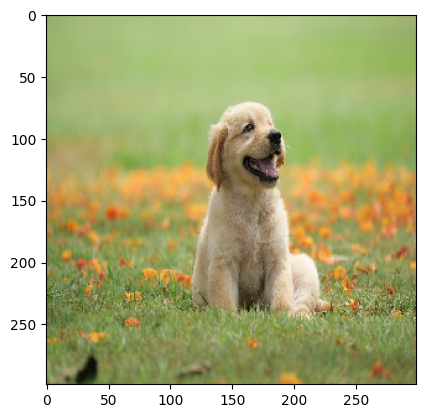

2023-01-31 15:45:32.993519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


('n02099601', 'golden_retriever', 0.76057166)
('n02099712', 'Labrador_retriever', 0.1271743)
('n02101556', 'clumber', 0.016783446)
('n02102318', 'cocker_spaniel', 0.015526118)
('n02104029', 'kuvasz', 0.0036808508)


In [2]:
#Same as the original LIME tutorial,
#here we create a standard InceptionV3 pretrained model 
#and use it on images by first preprocessing them with the preprocessing tools
inet_model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


images = transform_img_fn([os.path.join('data','5.jpg')])
# I'm dividing by 2 and adding 0.5 because of
# how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
plt.show()
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

#### Now we create an instance of LIME explainer with an arg _feature_selection='none'_ meaning we will consider all features of the image in our later explanation. You may also specify other args like kernel_width etc. For a complete list of args, cf. the comments in the sources code when defining the class.

In [3]:
explainer = lime_image.LimeImageExplainer(feature_selection='none')#kernel_width=0.1

#### First, let us explain the image _image[0]_ with the original LIME -- i.e. with option _model_regressor='non_Bay'_ .

Meanings behind other args, again, can be found in comments of the source codes when defining the function. E.g., _number_samples=200_ represents the number of perturbed samples used for the training of the local surrogate model.

the number of features: 96


/Users/xingyu/Documents/GitHub/BayLime/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


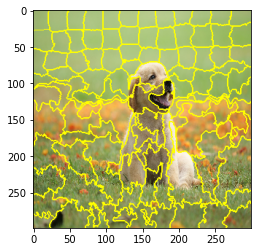

  0%|          | 0/200 [00:00<?, ?it/s]

using non_Bay option for model regressor
using non_Bay option for model regressor
using non_Bay option for model regressor


In [4]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=3, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='non_Bay')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

Now we have done the explanations for the top 3 labels. We have different ways to present the explanation results -- to show a few regarding the top label as the following:
1. Showing top 10 features and hide the rest. Also the 10 features could have both positive and negative contribution to the prediction.
2. Only showing the top 5 positive features without hiding the rest.
3. Or we can simply present the 'importance' of each feature as a list.

Note, the mean and variance information for the top 10 features are internal assertions that can be switched off (assuming they are repetitive in some cases). In this case, since we are using non-bay option, there is no mean/variance actually, so you see a 0 variance and mean really represents the fitted coefficient by the Linear Regressor.

For feature of segment 51
The mean of the (posterior) coefficient 0.08957261174411413
The variance of the (posterior) coefficient 0.0
For feature of segment 36
The mean of the (posterior) coefficient 0.06929649660951956
The variance of the (posterior) coefficient 0.0
For feature of segment 53
The mean of the (posterior) coefficient 0.06644756399532091
The variance of the (posterior) coefficient 0.0
For feature of segment 8
The mean of the (posterior) coefficient 0.060069368117613445
The variance of the (posterior) coefficient 0.0
For feature of segment 39
The mean of the (posterior) coefficient 0.05559169563188743
The variance of the (posterior) coefficient 0.0
For feature of segment 38
The mean of the (posterior) coefficient 0.04820560868164617
The variance of the (posterior) coefficient 0.0
For feature of segment 45
The mean of the (posterior) coefficient 0.04771084053636256
The variance of the (posterior) coefficient 0.0
For feature of segment 56
The mean of the (posterior) coeffici

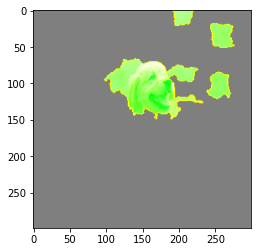

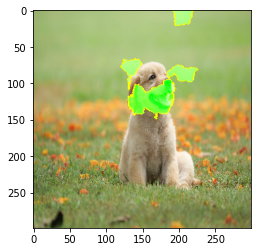

[('51', 0.08957261174411413), ('36', 0.06929649660951956), ('53', 0.06644756399532091), ('8', 0.060069368117613445), ('39', 0.05559169563188743), ('38', 0.04820560868164617), ('45', 0.04771084053636256), ('56', 0.04689402384807642), ('42', 0.044790979748445654), ('15', 0.04376763626600353), ('5', -0.0409633346886633), ('65', 0.03648983919964217), ('52', -0.03552084587452055), ('43', 0.03489591215737375), ('62', 0.03377314830532012), ('30', 0.03212198551378992), ('24', 0.031712238925806636), ('9', 0.031574468335548764), ('16', 0.03137428548334089), ('59', -0.031019411413714972), ('23', 0.030230938314348216), ('69', 0.029053803800203733), ('17', 0.028953590925033332), ('34', 0.02777046612286196), ('48', 0.02685688662442487), ('55', 0.025639007053964446), ('82', -0.025014166775612415), ('3', 0.02450437378039018), ('25', 0.024445479510993937), ('41', 0.024176815983176583), ('31', -0.023615573182708773), ('89', -0.023511194184329443), ('70', -0.023312471164472347), ('57', -0.022728628337851

In [5]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the image _image[0]_ with BayLIME but without any prior information -- i.e. with option _model_regressor='Bay_non_info_prior'_ .

Essentially we use a zero mean vector as prior knowledge with fitted precision parameters.

Note, you will see 1 set of fitted alpha and lambda parameters (cf. the BayLIME paper for the meanings of these two parameters..) that corresponds to the explanations to the top 1 label.

the number of features: 96


/Users/xingyu/Documents/GitHub/BayLime/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


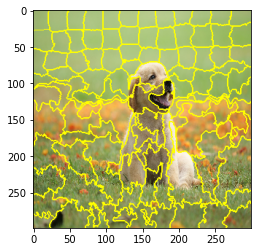

  0%|          | 0/200 [00:00<?, ?it/s]

using Bay_non_info_prior option for model regressor
Convergence after  12  iterations
the alpha is 189.35999603774744
the lambda is 3145.981311712462
the regulation term lambda/alpha is 16.61375885900069


In [6]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='Bay_non_info_prior')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

##### It is worth to note that the fitted alpha and lambda parameters are recorded in a CSV file './posterior_configure.csv'

For feature of segment 51
The mean of the (posterior) coefficient 0.05165533014067911
The variance of the (posterior) coefficient 0.00014488599557938904
For feature of segment 53
The mean of the (posterior) coefficient 0.039733478253316856
The variance of the (posterior) coefficient 0.00014591009551197983
For feature of segment 65
The mean of the (posterior) coefficient 0.0373503528833188
The variance of the (posterior) coefficient 0.00014678000827578964
For feature of segment 38
The mean of the (posterior) coefficient 0.033358543519431225
The variance of the (posterior) coefficient 0.0001527117533906539
For feature of segment 69
The mean of the (posterior) coefficient 0.028523910361758525
The variance of the (posterior) coefficient 0.00014728385490765357


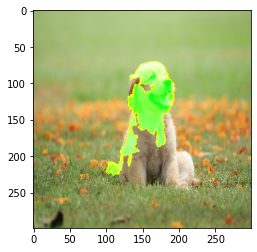

[('51', 0.05165533014067911), ('53', 0.039733478253316856), ('65', 0.0373503528833188), ('38', 0.033358543519431225), ('69', 0.028523910361758525), ('49', 0.02249208824111831), ('36', 0.02200496663810373), ('42', 0.020908062961989056), ('30', 0.019648776040665644), ('15', 0.01856525085344236), ('6', 0.017983297340584504), ('52', 0.01762622503713344), ('78', 0.015675529952170933), ('73', 0.015477198558358888), ('61', 0.015414561138917262), ('70', 0.014427994112446465), ('58', 0.01430793372985479), ('80', 0.013896700305580018), ('68', 0.01346634897444476), ('50', -0.012475590751442039), ('35', 0.012052984830362566), ('20', 0.01201670350483323), ('33', 0.01183486319398521), ('0', -0.01159644750862884), ('28', 0.011522921625488666), ('54', 0.011259972107025281), ('56', 0.011180730074929479), ('10', 0.01114633318818249), ('74', 0.010128785300213172), ('2', 0.010080062281103721), ('57', -0.010039845038081729), ('32', 0.010014628177386716), ('64', 0.009901187414491473), ('87', 0.0097312694013

In [7]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the top 1 label of the image _image[0]_ with BayLIME and with full prior knowledge -- i.e. with option _model_regressor='Bay_info_prior'_ .

You will see, in this case, we read the alpha and lambda parameters from the CSV file  './configure.csv'. Moreover, after the explanation, we will again write the parameters into the  './posterior_configure.csv' file.

the number of features: 96


/Users/xingyu/Documents/GitHub/BayLime/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


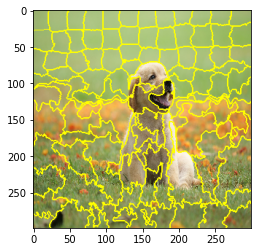

  0%|          | 0/200 [00:00<?, ?it/s]

using Bay_info_prior option for model regressor
the alpha is 1.0
the lambda is 1000.0
the regulation term lambda/alpha is 1000.0


In [8]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=1, batch_size=10,
                                         num_samples=200,model_regressor='Bay_info_prior')

The following code simply reads the values of the alpha and lambda parameters from the CSV file into two variables.

In [9]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

Now in the current explanation, only the data has spoken for themselves (i.e. the second term in the eq. (15) in the BayLIME paper), while the priors knowledge hasn't been combined in (the first term in the eq. (15) in the BayLIMe paper). Now let us combine the prior knowledge (a prior mean vector for all features) that stored in the file '.\data\prior_knowledge_5_jpg.csv'

In [10]:

import pandas as pd
pr=pd.read_csv('./data/prior_knowledge_5_jpg.csv').to_numpy()[0]
print(pr)
explanation=calculate_posteriors.get_posterior(explanation,pr,
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])


[ 0.00000000e+00 -5.23320000e-03  7.54998700e-03 -8.55449000e-04
  3.94703800e-03 -6.17783900e-03 -8.19437500e-03  9.74064900e-03
 -8.08969000e-04  1.49263290e-02  4.31087700e-03 -2.19579200e-03
  2.00041070e-02  6.57076700e-03 -4.07356500e-03  6.17464100e-03
  1.73574640e-02  9.41309100e-03  1.02501100e-03 -1.53062590e-02
 -1.57279200e-03 -1.48478600e-03  9.18400700e-03  2.06287720e-02
  1.10606340e-02  7.02470000e-03 -8.59385000e-04  1.58121150e-02
  9.04383900e-03  9.81035220e-02 -4.06174000e-04  5.28329300e-03
  2.40797690e-02  9.19124000e-04  1.24470868e-01  9.83462200e-03
  1.45581125e-01 -1.07631350e-02  8.47256300e-03  1.87454280e-02
 -2.07241900e-03 -8.34496100e-03 -5.59272000e-03 -3.59730400e-03
  2.64035300e-03 -2.76775600e-03 -7.18043000e-04  4.55971140e-02
  5.85015600e-03 -1.77411670e-02  1.59057950e-02  6.84449000e-04
  8.44905000e-04  2.04124800e-02  1.00191910e-02  2.00075800e-03
 -5.91076900e-03 -1.79824400e-03 -3.32128800e-03  5.96310000e-04
  6.74444300e-03 -1.62439

For feature of segment 51
The mean of the (posterior) coefficient 0.002366888679165872
The variance of the (posterior) coefficient 0.0009754643428022271
For feature of segment 34
The mean of the (posterior) coefficient 0.0021870392178565934
The variance of the (posterior) coefficient 0.0009755444152541558
For feature of segment 36
The mean of the (posterior) coefficient 0.002094934320679207
The variance of the (posterior) coefficient 0.0009754413933079396
For feature of segment 53
The mean of the (posterior) coefficient 0.0019366732724117918
The variance of the (posterior) coefficient 0.0009754272732300494
For feature of segment 38
The mean of the (posterior) coefficient 0.0019316202895519193
The variance of the (posterior) coefficient 0.000975456083655466


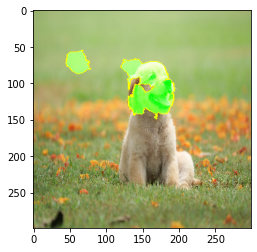

[('51', 0.002366888679165872), ('34', 0.0021870392178565934), ('36', 0.002094934320679207), ('53', 0.0019366732724117918), ('38', 0.0019316202895519193), ('65', 0.0017960329299437125), ('29', 0.0014324791341849392), ('16', 0.0013550253827826805), ('12', 0.0013331545033890152), ('81', 0.0012310417239920863), ('63', 0.001172270167152088), ('42', 0.0011483371114440503), ('59', 0.0011271373059019492), ('25', 0.0010033091689830927), ('93', 0.0010005536623381782), ('19', 0.0009983230611249382), ('23', 0.0009860489287194742), ('1', -0.0009470228125802133), ('68', 0.0009195002160831147), ('71', 0.0009173355959243641), ('52', 0.0009155023240543418), ('57', 0.0008799779173975752), ('0', 0.0008219977722141495), ('10', 0.0008022993768704752), ('56', 0.0007768200602445247), ('64', -0.0007710973403885521), ('3', -0.000761272076930543), ('18', 0.000746838805092186), ('27', 0.0007157089133267413), ('11', 0.0007106231131403124), ('73', 0.0007081921518043442), ('47', 0.0006726459580445039), ('66', 0.000

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Finally, we explain the top 1 label of the image _image[0]_ with BayLIME and with *partial* prior knowledge -- i.e. with option _model_regressor='BayesianRidge_inf_prior_fit_alpha'_ .

You will see, in this case, we fit the alpha from data and read the lambda parameter from the CSV file  './configure.csv'. Then, after the explanation, we will again write both the alpha and lambda parameters into the  './posterior_configure.csv' file.

the number of features: 96


/Users/xingyu/Documents/GitHub/BayLime/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


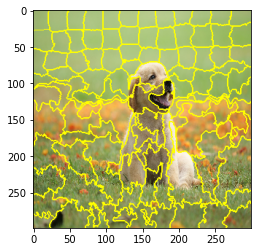

  0%|          | 0/200 [00:00<?, ?it/s]

using Bay_info_prior_fixed_lambda_fit_alpha option for model regressor
Convergence after  3  iterations
the alpha is 214.54885717246603
the lambda is 1000.0
the regulation term lambda/alpha is 4.660943027984277


In [12]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='BayesianRidge_inf_prior_fit_alpha')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

The rest of the steps are the same as before (i.e. the case using the full prior knowledge...)

In [13]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

In [18]:
pr=pd.read_csv('./data/prior_knowledge_5_jpg.csv').to_numpy()[0]
print("I am printing the prior knowldege for the first few features")
print(pr)
explanation=calculate_posteriors.get_posterior(explanation,pr,
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])

I am printing the prior knowldege for the first few features
[ 0.00000000e+00 -5.23320000e-03  7.54998700e-03 -8.55449000e-04
  3.94703800e-03 -6.17783900e-03 -8.19437500e-03  9.74064900e-03
 -8.08969000e-04  1.49263290e-02  4.31087700e-03 -2.19579200e-03
  2.00041070e-02  6.57076700e-03 -4.07356500e-03  6.17464100e-03
  1.73574640e-02  9.41309100e-03  1.02501100e-03 -1.53062590e-02
 -1.57279200e-03 -1.48478600e-03  9.18400700e-03  2.06287720e-02
  1.10606340e-02  7.02470000e-03 -8.59385000e-04  1.58121150e-02
  9.04383900e-03  9.81035220e-02 -4.06174000e-04  5.28329300e-03
  2.40797690e-02  9.19124000e-04  1.24470868e-01  9.83462200e-03
  1.45581125e-01 -1.07631350e-02  8.47256300e-03  1.87454280e-02
 -2.07241900e-03 -8.34496100e-03 -5.59272000e-03 -3.59730400e-03
  2.64035300e-03 -2.76775600e-03 -7.18043000e-04  4.55971140e-02
  5.85015600e-03 -1.77411670e-02  1.59057950e-02  6.84449000e-04
  8.44905000e-04  2.04124800e-02  1.00191910e-02  2.00075800e-03
 -5.91076900e-03 -1.79824400e

For feature of segment 51
The mean of the (posterior) coefficient 0.07509357173078679
The variance of the (posterior) coefficient 0.0002263415633260018
For feature of segment 65
The mean of the (posterior) coefficient 0.05205935822696475
The variance of the (posterior) coefficient 0.00024084712852656914
For feature of segment 36
The mean of the (posterior) coefficient 0.050039716722321874
The variance of the (posterior) coefficient 0.00023570906714648343
For feature of segment 53
The mean of the (posterior) coefficient 0.04866301525797584
The variance of the (posterior) coefficient 0.0002321135489206997
For feature of segment 7
The mean of the (posterior) coefficient 0.046065719910892346
The variance of the (posterior) coefficient 0.0002444480941098407


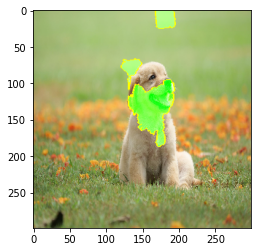

[('51', 0.07509357173078679), ('65', 0.05205935822696475), ('36', 0.050039716722321874), ('53', 0.04866301525797584), ('7', 0.046065719910892346), ('84', 0.039518601239862), ('64', 0.03859397888018373), ('39', 0.03388672260503378), ('38', 0.03281200907923032), ('77', 0.032633180347617675), ('48', 0.031258958371881355), ('73', 0.028541415210342324), ('87', 0.027634472228499445), ('54', 0.02616531292578948), ('15', -0.02614770520084088), ('50', 0.024819273959868722), ('22', 0.024533454716148012), ('30', -0.024441762693148), ('90', 0.023951335518592354), ('91', 0.023827578030385693), ('9', -0.022677883284625056), ('47', 0.02248386567515325), ('92', 0.02158925328932687), ('85', 0.020533608747655672), ('33', 0.019458509956923498), ('61', 0.01918769791810942), ('0', 0.01915947571904644), ('52', 0.019034500921236805), ('74', 0.01835172848118289), ('31', -0.01793560180951707), ('72', 0.016880498812514626), ('19', 0.016519416207170918), ('81', 0.016446906372661812), ('20', 0.016333847697106343)

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))